Why need gridding?
- data is a set of measurements along fl and tl
- unevenly spaced in 2d
- strongly anisotropic (dense along track, sparse cross-track)

What gridding does?
Converts path based measurements into a continuous 2D field

(x_i, y_i, F_i) -> F(x,y)
SO?
- allows us to compare values between lines
- see spatial patterns 
- hand the map to downstream algo

Without gridding:
- cannot compute spatial derivatives
- cannot contour
- cannot to upward continuation
- cannot compare surveys easily
- cannot export to GIS easily

What MAMMAL used for gridding - RBF: fit smooth surface using radial basis function
Why it’s popular:

- Produces smooth, continuous surfaces
- Handles irregular spacing well
- Good crossover behavior
- Very stable for airborne data

Downside:

- Can over-smooth
- Computationally heavier
- Can smear line-parallel errors if leveling is bad

This is why MAMMAL:

1) Tie-levels first
2) Then RBF
3) Then LPF

In [1]:
import pandas as pd

in_path = "../data/sim_dataTL/sim_magnav_leveled_master.csv"
df = pd.read_csv(in_path)

df.columns


Index(['time_s', 'lat', 'lon', 'alt_m', 'mag_scalar_nT',
       'mag_anomaly_injected_nT', 'mag_residual_nT', 'heading_deg',
       'turn_score_deg', 'is_turn', 'LINE', 'east_m', 'north_m', 'line',
       'LINE_TYPE', 'yaw_rad', 'pitch_rad', 'roll_rad', 'yaw_deg', 'pitch_deg',
       'roll_deg', 'psi_deg', 'psi_rad', 'F_raw', 'F_headcorr', 'delta_F',
       'F_smooth_sg', 'F_smooth_med', 'F_smooth_lp', 'F', 'TL_GROUP',
       'F_leveled_line', 'F_leveled_plane'],
      dtype='object')

A GeoTIFF is:

A raster grid + spatial metadata + scientific values

In [2]:
import osgeo.gdal

In [4]:
import numpy as np
import pandas as pd

# choose what to grid
F_COL = "F_leveled_line"          # linewise result
# F_COL = "F_leveled_plane"  # plane-wide result
# F_COL = "F_smooth_lp"      # before leveling (for comparison)

lat = df["lat"].to_numpy(float)
lon = df["lon"].to_numpy(float)
F   = df[F_COL].to_numpy(float)

# Optional: mask NaNs
m = np.isfinite(lat) & np.isfinite(lon) & np.isfinite(F)
lat, lon, F = lat[m], lon[m], F[m]

print("Using:", F_COL, "N=", len(F))
print("lat range:", lat.min(), lat.max())
print("lon range:", lon.min(), lon.max())
print("F range:", F.min(), F.max())


Using: F_leveled_line N= 148016
lat range: -27.116237 -27.098186786758287
lon range: 131.084472 131.09657455272065
F range: -17.82040965732213 375.0338953456881


In [5]:
 #build a regular grid (lat/lon)
# since FL spacing is 100 m use 25 m grid?

# grid spacing in meters
dx_m = 25.0
dy_m = 25.0

# Convert meters -> degrees approximately at mean latitude
lat0 = float(np.mean(lat))
m_per_deg_lat = 111_320.0
m_per_deg_lon = 111_320.0 * np.cos(np.deg2rad(lat0))

dlat = dy_m / m_per_deg_lat
dlon = dx_m / m_per_deg_lon

lat_grid = np.arange(lat.min(), lat.max() + dlat, dlat)
lon_grid = np.arange(lon.min(), lon.max() + dlon, dlon)

LON, LAT = np.meshgrid(lon_grid, lat_grid)  # shapes (Ny, Nx)

print("Grid shape:", LAT.shape, "dlat:", dlat, "dlon:", dlon)


Grid shape: (82, 49) dlat: 0.0002245777937477542 dlon: 0.00025229053196873015


In [6]:
#interpolate onto the grid (using griddata)
from scipy.interpolate import griddata

points = np.column_stack([lon, lat])

# method options: "nearest", "linear", "cubic"
Z_linear = griddata(points, F, (LON, LAT), method="linear")
Z_near   = griddata(points, F, (LON, LAT), method="nearest")

# Fill holes in linear with nearest (common trick)
Z = np.where(np.isnan(Z_linear), Z_near, Z_linear)

print("NaNs after fill:", np.isnan(Z).sum())


NaNs after fill: 0


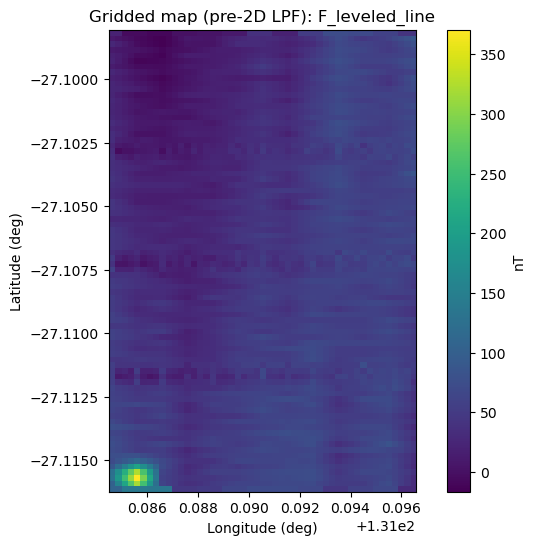

In [ ]:
#quick plot before we filter
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.imshow(Z, origin="lower",
           extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()])
plt.colorbar(label="nT")
plt.title(f"Gridded map (pre-2D LPF): {F_COL}")
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.show()


In [8]:
#remove corrugation / striping
def butterworth_lowpass_2d(Z, dx_m, dy_m, cutoff_wavelength_m=200.0, order=4):
    """
    2D Butterworth LPF in frequency domain.
    cutoff_wavelength_m: features smaller than this get smoothed more.
    """
    Z = Z.astype(float)
    Z0 = Z.copy()

    # remove mean to avoid DC dominating
    mean = np.nanmean(Z0)
    Z0 = Z0 - mean

    # replace NaNs with 0 for FFT (okay because we filled already)
    Z0 = np.nan_to_num(Z0, nan=0.0)

    ny, nx = Z0.shape

    fx = np.fft.fftfreq(nx, d=dx_m)  # cycles/m
    fy = np.fft.fftfreq(ny, d=dy_m)  # cycles/m
    FX, FY = np.meshgrid(fx, fy)

    FR = np.sqrt(FX**2 + FY**2)      # radial frequency (cycles/m)

    f_c = 1.0 / cutoff_wavelength_m  # cycles/m
    H = 1.0 / (1.0 + (FR / f_c)**(2*order))

    FZ = np.fft.fft2(Z0)
    FZ_filt = FZ * H
    Z_filt = np.real(np.fft.ifft2(FZ_filt))

    return Z_filt + mean

Z_filt = butterworth_lowpass_2d(Z, dx_m=dx_m, dy_m=dy_m, cutoff_wavelength_m=200.0, order=4)


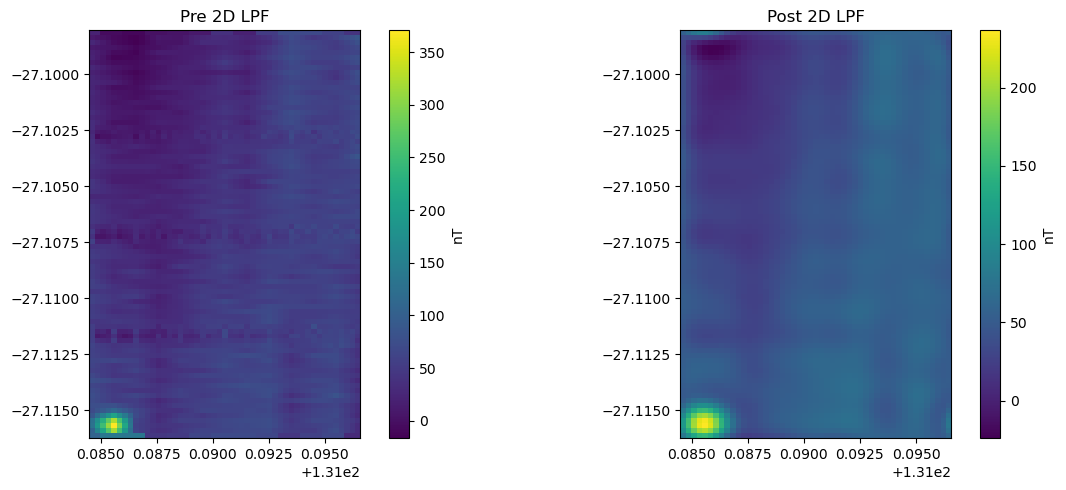

In [9]:
#plot again
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(Z, origin="lower",
           extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()])
plt.title("Pre 2D LPF")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.imshow(Z_filt, origin="lower",
           extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()])
plt.title("Post 2D LPF")
plt.colorbar(label="nT")

plt.tight_layout()
plt.show()


In [10]:
#exporting geotiff (minimal WGS84)
from osgeo import gdal, osr
import os

def export_geotiff_scalar(out_path, lats, lons, scalar2d, epsg=4326):
    lats = np.asarray(lats)
    lons = np.asarray(lons)
    Z = np.asarray(scalar2d)

    assert Z.shape == (len(lats), len(lons)), f"Expected {(len(lats), len(lons))}, got {Z.shape}"

    # ensure ascending lats for geotransform math
    if lats[0] > lats[-1]:
        lats = lats[::-1]
        Z = Z[::-1, :]

    ny, nx = Z.shape
    xmin, xmax = float(lons.min()), float(lons.max())
    ymin, ymax = float(lats.min()), float(lats.max())

    xres = (xmax - xmin) / (nx - 1)
    yres = (ymax - ymin) / (ny - 1)

    geotransform = (xmin, xres, 0.0, ymax, 0.0, -yres)

    driver = gdal.GetDriverByName("GTiff")
    ds = driver.Create(out_path, nx, ny, 1, gdal.GDT_Float32)
    ds.SetGeoTransform(geotransform)

    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    ds.SetProjection(srs.ExportToWkt())

    band = ds.GetRasterBand(1)
    band.SetNoDataValue(-9999.0)

    Z_out = np.where(np.isnan(Z), -9999.0, Z).astype(np.float32)

    # write flipped vertically so row0 corresponds to ymax
    band.WriteArray(Z_out[::-1, :])

    band.FlushCache()
    ds.FlushCache()
    ds = None

    return out_path

out_dir = "outputs"
os.makedirs(out_dir, exist_ok=True)

tif_path = os.path.join(out_dir, f"map_{F_COL}_dx{int(dx_m)}m_LPF200m.tif")
export_geotiff_scalar(tif_path, lat_grid, lon_grid, Z_filt)

print("Saved GeoTIFF:", tif_path)


Saved GeoTIFF: outputs\map_F_leveled_line_dx25m_LPF200m.tif


<xarray.DataArray (band: 1, y: 82, x: 49)> Size: 16kB
[4018 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 392B 131.1 131.1 131.1 131.1 ... 131.1 131.1 131.1
  * y            (y) float64 656B -27.1 -27.1 -27.1 ... -27.12 -27.12 -27.12
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0


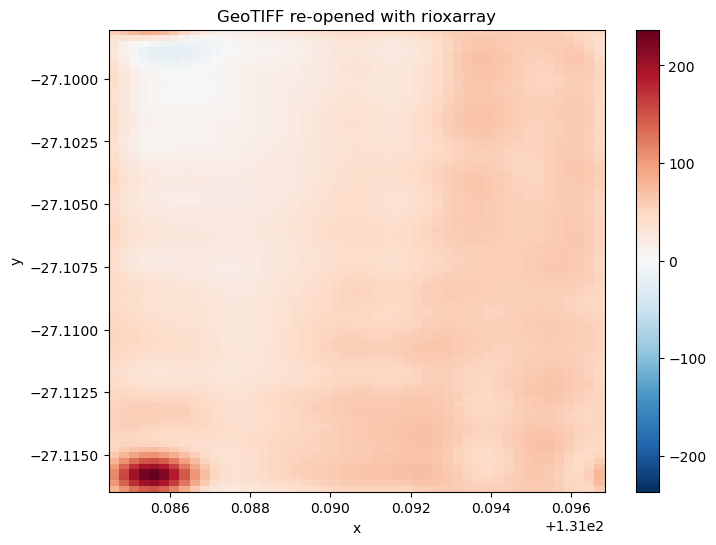

In [11]:
import rioxarray as rxr

m = rxr.open_rasterio(tif_path)
print(m)

plt.figure(figsize=(8,6))
m[0].plot()
plt.title("GeoTIFF re-opened with rioxarray")
plt.show()
